# Package gm_submodular
## Example using submodular maximization (K-medoids objective)

In [1]:
import gm_submodular
help(gm_submodular)

Help on package gm_submodular:

NAME
    gm_submodular

FILE
    /home/gyglim/code/gm_submodular/gm_submodular/__init__.py

DESCRIPTION
    This package contains code for submodular maximization and
    structured learning using stochastic gradient decent.
    It allows to learn an objective function as a linear combination of simpler functions f, i.e.
    
    .. math:: o(\mathbf{x_\mathcal{V}},\mathbf{y})=\mathbf{w^\mathrm{T}}\mathbf{f}(\mathbf{x_\mathcal{V},y}).
    This is known as the structured SVM problem.
    
    In this package, we use stochastic gradient descent in combination with specialized algorithms for submodular maximization.
    In particular, it implements the algorithms of [1,2,4] and allows to use AdaGrad [6,7] in the optimization.
    Furthermore it allows to use supermodular loss functions, by approximating them using a variant
    of a submodular-supermodular procedure based on [5].
    
    
    You can find an example on how to do submodular maximization and 

In [2]:
# Load standard packages
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import numpy as np
%matplotlib inline

# Load submodular package
import gm_submodular

In [3]:
# Load examples
import gm_submodular.example_objectives as ex

### Create a new DataElement
Needs datapoints x and the function getDistances (for the k-medoids objective)

In [4]:
num_points=50
class St(gm_submodular.DataElement):
    budget=5
    x=np.random.rand(num_points,2)
    dist_v=dist.pdist(x)
    Y=np.ones(num_points)
    def getCosts(self):
        return np.ones(num_points)
    def getDistances(self):
        d=dist.squareform(self.dist_v)
        return np.multiply(d,d)
S=St()

### Submodular Inference

In [5]:
reload(ex)
reload(gm_submodular)
# Define the desired objectives
objectives=[ex.representativeness_shell(S), ex.random_shell(S)]
weights=[1,0]

# Maximize the objectives
selected_elements,score,minoux_bound=gm_submodular.leskovec_maximize(S,weights,objectives,budget=5)

Selected points: 24 15 47 44 43


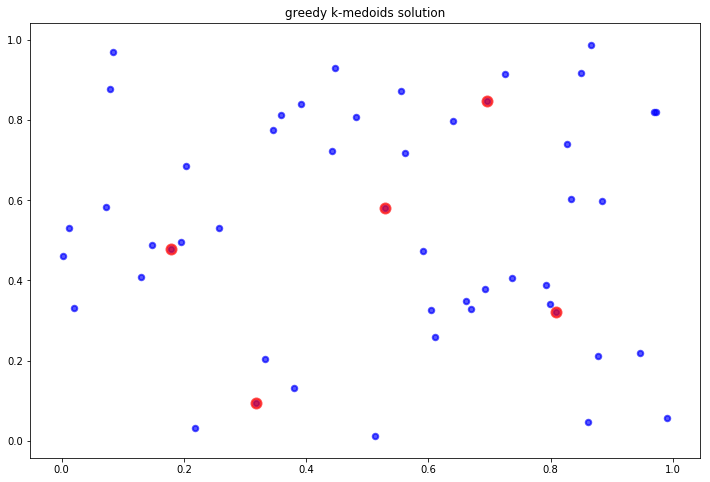

In [7]:
# Plot results
plt.figure(figsize=(12,8)) # Definition of a larger figure (in inches)
plt.scatter(S.x[:,0],S.x[:,1], c='blue', alpha=0.66, s=30, linewidths=2)
plt.scatter(S.x[selected_elements,0],S.x[selected_elements,1], c='red', s=100, alpha=0.66, linewidths=2)
print('Selected points: %s' % ' '.join(map(lambda x: str(x),selected_elements)))
plt.title('greedy k-medoids solution');

## Learning of Submodular Mixture weights

INFO:gm_submodular:SGDparams
-----
          use_ada_grad:	True
     use_l1_projection:	True
              max_iter:	10
          learn_lambda:	None
 norm_objective_scores:	False
                    nu:	<function <lambda> at 0x7f8e788fc9b0>
              momentum:	0.0
INFO:gm_submodular:regularizer lambda: 0.284
INFO:gm_submodular:Example 0 of 500
INFO:gm_submodular:Example 50 of 500
INFO:gm_submodular:Example 100 of 500
INFO:gm_submodular:Example 150 of 500
INFO:gm_submodular:Example 200 of 500
INFO:gm_submodular:Example 250 of 500
INFO:gm_submodular:Example 300 of 500
INFO:gm_submodular:Example 350 of 500
INFO:gm_submodular:Example 400 of 500
INFO:gm_submodular:Example 450 of 500

INFO:gm_submodular:----------------------------

INFO:gm_submodular:Weights:

INFO:gm_submodular: representativeness_shell: 99.870%
INFO:gm_submodular:         random_shell: 0.010%
INFO:gm_submodular:         random_shell: 0.030%
INFO:gm_submodular:         random_shell: 0.050%
INFO:gm_submodular:         r

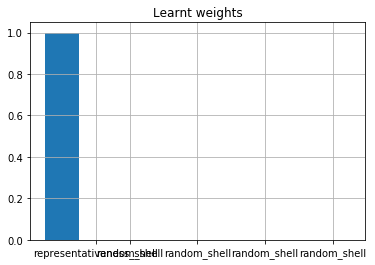

In [8]:
# Create tranining data (use result of the k-modoid objective)
training_examples=[]
reload(gm_submodular)
gm_submodular.logger.setLevel('INFO')
for i in range(0,50):
    S=St()
    S.budget=10
    S.clusters=np.array(np.random.rand(len(S.x))*5,np.int)
    selected_elements,score,_=gm_submodular.leskovec_maximize(S,weights,objectives,S.budget)
    S.y_gt=selected_elements
    training_examples.append(S)
    
# Learn the weights. Given that we used the k-medoid results as ground truth, this objective should get all the weight
shells=[ex.representativeness_shell,ex.random_shell,ex.random_shell,ex.random_shell,ex.random_shell]
loss=ex.intersect_complement_loss

# Use AdaGrad and a l-1 semiball projection (leads to sparser solutions, i.e. is more robust to noise)
params=gm_submodular.SGDparams(use_l1_projection=True,max_iter=10,use_ada_grad=True)

#Alternatively, one could use vanilla SGD
#params=gm_submodular.SGDparams()

#############
# LEARNING
# The weights are learnt using SGD (Note: This hardly converges, so define a reasonable number of maximal iterations)
# Also, given the stochasticity of the learning, you can expect some variance in the results.
####
learnt_weights,_=gm_submodular.learnSubmodularMixture(training_examples, shells,loss,params=params)


# Plot the learnt weights
width = 0.5
plt.bar(np.arange(0,len(learnt_weights)),learnt_weights,width)
plt.xticks(np.arange(0,len(learnt_weights))+learnt_weights/2., map(lambda x: x.func_name, shells))
plt.title('Learnt weights')
plt.grid()